In [1]:
from email.generator import Generator

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
# hyper parameters
latent_dim = 100
num_labels = 10
image_size = 28
batch_size = 64
epochs = 50
learning_rate = 2e-4
device = torch.device("mps" if torch.mps.is_available() else "cpu")

if torch.device('mps').type == "mps" and torch.backends.mps.is_available():
    print("MPS is available")
else:
    print("MPS is not available")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

mnist = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
data_loader = DataLoader(mnist, batch_size=batch_size, shuffle=True)


MPS is available


In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_embedding = nn.Embedding(num_embeddings=num_labels, embedding_dim=num_labels)

        self.layers = nn.Sequential(
            nn.Linear(latent_dim + num_labels, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, image_size * image_size),
            nn.Tanh()            
        )

    def forward(self, noise, labels):
        noise = noise.view(noise.size(0), latent_dim)
        labels = self.label_embedding(labels)
        combined_input = torch.cat((noise, labels), dim=1)
        output = self.layers(combined_input)
        return output.view(combined_input.size(0), 1, image_size, image_size)

In [4]:
class CNN_Generator(nn.Module):
    def __init__(self):
        super(CNN_Generator, self).__init__()
        
        self.label_embedding = nn.Embedding(num_embeddings=num_labels, embedding_dim=num_labels)
        
        self.fc_layer = nn.Linear(latent_dim + num_labels, 7 * 7 * 128)
        
        self.conv_layers = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1), # 14x14 128 channels
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),    
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1), # 28x28 64 channels
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1), # 28x28 32 channels
            nn.Tanh()            
        )
        
    def forward(self, noise, labels):
        noise = noise.view(noise.size(0), latent_dim)
        labels = self.label_embedding(labels)
        combined_input = torch.cat((noise, labels), dim=1)
        output = self.fc_layer(combined_input)
        reshaped = output.view(output.size(0), 128, 7, 7)
        output = self.conv_layers(reshaped)
        return output.view(combined_input.size(0), 1, image_size, image_size)

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.label_embedding = nn.Embedding(num_embeddings=num_labels, embedding_dim=num_labels)
        
        self.layers = nn.Sequential(
            nn.Linear(image_size * image_size + num_labels, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.1),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.1),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.1),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        
    def forward(self, image, labels):
        image = image.view(image.size(0), image_size * image_size)
        embedding = self.label_embedding(labels)
        combined_input = torch.cat((image, embedding), dim=1)
        return self.layers(combined_input)                      # out.squeeze()?

In [6]:
class CNN_Discriminator(nn.Module):
    def __init__(self):
        super(CNN_Discriminator, self).__init__()
        
        self.label_embedding = nn.Embedding(num_embeddings=num_labels, embedding_dim=image_size*image_size)
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=2, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(7 * 7 * 64, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.1),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.1),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        
    def forward(self, image, labels):
        # embed labels and concat as extra channel
        label_embeddings = self.label_embedding(labels).view(labels.size(0), 1, image_size, image_size)
        input_with_labels = torch.cat((image, label_embeddings), dim=1)
        
        # conv layers
        processed_image = self.conv_layers(input_with_labels)
        flattened_image = processed_image.view(processed_image.size(0), -1)
        
        # fc layers
        return self.fc_layers(flattened_image) 


In [7]:
# create models
generator = CNN_Generator().to(device)
discriminator = CNN_Discriminator().to(device)

adversarial_loss = nn.BCELoss()

optim_gen = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optim_disc = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

Epoch 1 of 50: gen_loss = 0.7274, disc_loss = 1.163840413093567


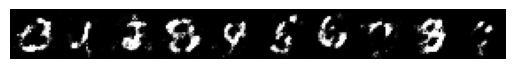

Epoch 2 of 50: gen_loss = 1.3148, disc_loss = 0.9297975301742554


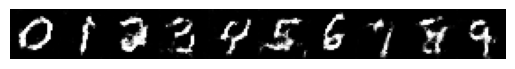

Epoch 3 of 50: gen_loss = 0.9897, disc_loss = 1.1696748733520508


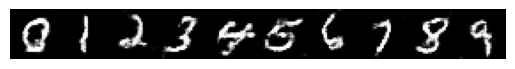

Epoch 4 of 50: gen_loss = 0.7224, disc_loss = 1.1229619979858398


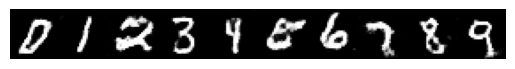

Epoch 5 of 50: gen_loss = 0.8991, disc_loss = 1.3201041221618652


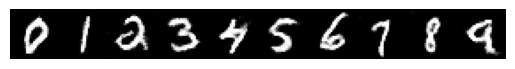

Epoch 6 of 50: gen_loss = 1.1096, disc_loss = 1.309954285621643


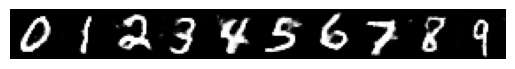

Epoch 7 of 50: gen_loss = 0.6732, disc_loss = 1.2907838821411133


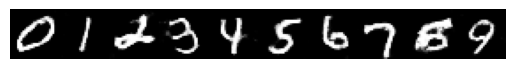

Epoch 8 of 50: gen_loss = 0.9167, disc_loss = 1.1831371784210205


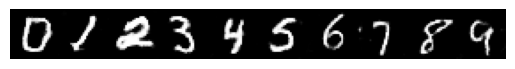

Epoch 9 of 50: gen_loss = 1.2028, disc_loss = 1.1989506483078003


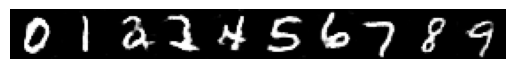

Epoch 10 of 50: gen_loss = 0.8495, disc_loss = 1.281174898147583


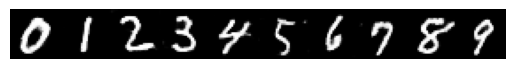

Epoch 11 of 50: gen_loss = 0.8839, disc_loss = 1.2682714462280273


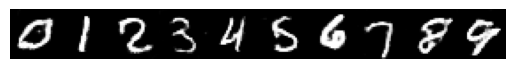

Epoch 12 of 50: gen_loss = 0.8834, disc_loss = 1.2311699390411377


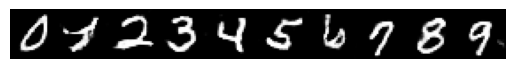

Epoch 13 of 50: gen_loss = 0.9944, disc_loss = 1.2327568531036377


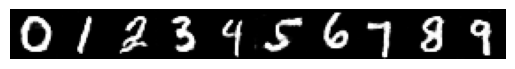

Epoch 14 of 50: gen_loss = 1.0321, disc_loss = 1.1953414678573608


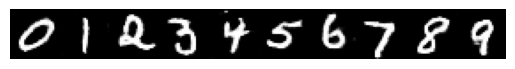

Epoch 15 of 50: gen_loss = 1.1044, disc_loss = 1.4630894660949707


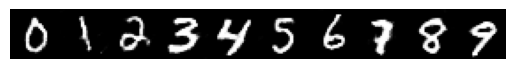

Epoch 16 of 50: gen_loss = 1.1259, disc_loss = 1.045979619026184


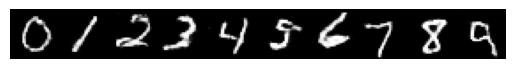

Epoch 17 of 50: gen_loss = 1.0167, disc_loss = 1.3705978393554688


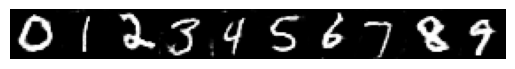

Epoch 18 of 50: gen_loss = 1.0514, disc_loss = 1.137916088104248


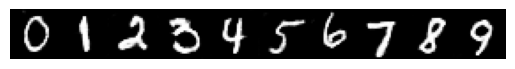

Epoch 19 of 50: gen_loss = 0.8831, disc_loss = 1.0471999645233154


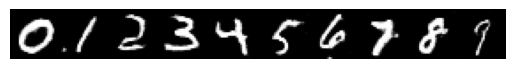

Epoch 20 of 50: gen_loss = 0.9735, disc_loss = 1.162224292755127


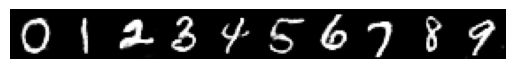

Epoch 21 of 50: gen_loss = 1.1307, disc_loss = 0.9155473709106445


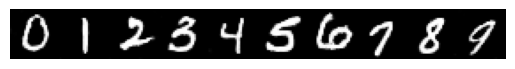

Epoch 22 of 50: gen_loss = 1.1048, disc_loss = 0.9048469066619873


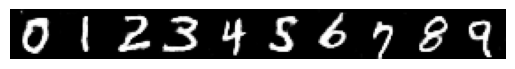

Epoch 23 of 50: gen_loss = 1.0848, disc_loss = 0.994933009147644


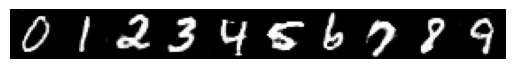

Epoch 24 of 50: gen_loss = 1.3145, disc_loss = 1.1208653450012207


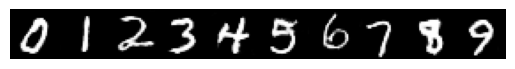

Epoch 25 of 50: gen_loss = 1.3288, disc_loss = 1.0595799684524536


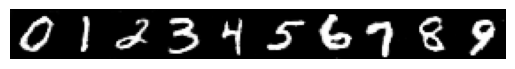

Epoch 26 of 50: gen_loss = 1.2273, disc_loss = 1.023360013961792


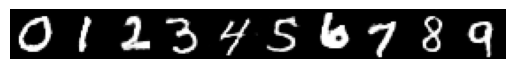

Epoch 27 of 50: gen_loss = 1.3734, disc_loss = 1.1322274208068848


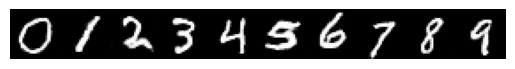

Epoch 28 of 50: gen_loss = 1.1296, disc_loss = 1.0265575647354126


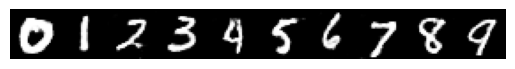

Epoch 29 of 50: gen_loss = 1.2198, disc_loss = 0.9776533842086792


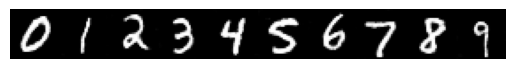

Epoch 30 of 50: gen_loss = 1.4573, disc_loss = 0.8823988437652588


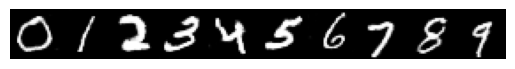

Epoch 31 of 50: gen_loss = 1.1479, disc_loss = 1.1199820041656494


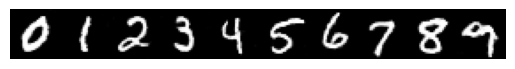

Epoch 32 of 50: gen_loss = 1.4834, disc_loss = 0.8599069714546204


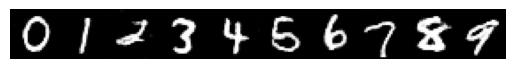

Epoch 33 of 50: gen_loss = 1.2258, disc_loss = 0.8240358233451843


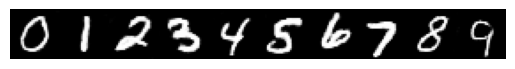

Epoch 34 of 50: gen_loss = 1.2338, disc_loss = 0.9803630113601685


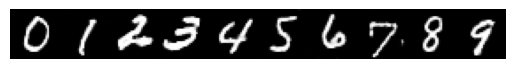

Epoch 35 of 50: gen_loss = 1.1410, disc_loss = 0.9987679123878479


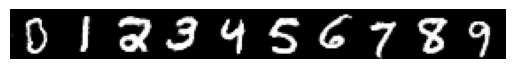

Epoch 36 of 50: gen_loss = 1.6395, disc_loss = 1.0650465488433838


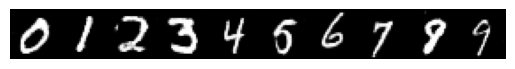

Epoch 37 of 50: gen_loss = 1.1276, disc_loss = 0.9056674242019653


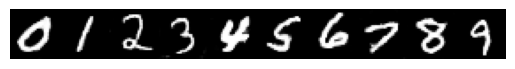

Epoch 38 of 50: gen_loss = 1.9843, disc_loss = 0.8864864110946655


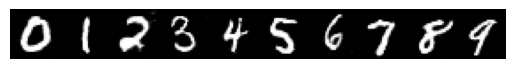

Epoch 39 of 50: gen_loss = 1.2438, disc_loss = 0.8271437287330627


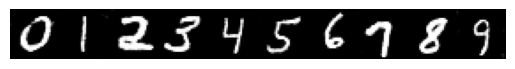

Epoch 40 of 50: gen_loss = 1.4885, disc_loss = 0.8020453453063965


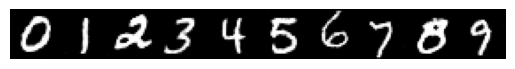

Epoch 41 of 50: gen_loss = 1.2137, disc_loss = 1.0769075155258179


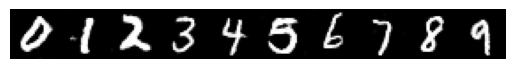

Epoch 42 of 50: gen_loss = 1.5824, disc_loss = 0.9226354360580444


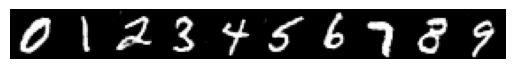

Epoch 43 of 50: gen_loss = 0.9789, disc_loss = 1.0896157026290894


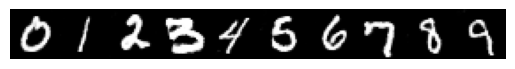

Epoch 44 of 50: gen_loss = 1.7869, disc_loss = 0.8898561000823975


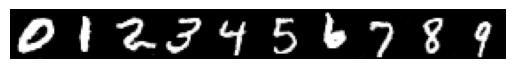

Epoch 45 of 50: gen_loss = 1.4172, disc_loss = 0.925537109375


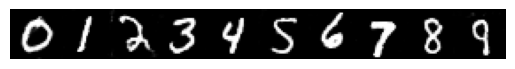

Epoch 46 of 50: gen_loss = 1.5117, disc_loss = 0.7326376438140869


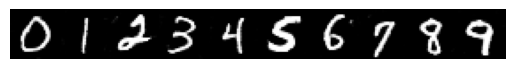

Epoch 47 of 50: gen_loss = 1.6039, disc_loss = 0.7427924871444702


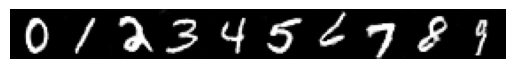

Epoch 48 of 50: gen_loss = 1.8577, disc_loss = 0.7805233001708984


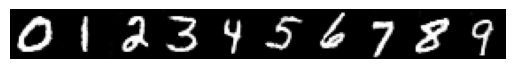

Epoch 49 of 50: gen_loss = 1.9765, disc_loss = 0.808401346206665


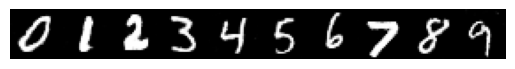

Epoch 50 of 50: gen_loss = 2.1399, disc_loss = 1.0645132064819336


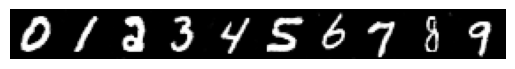

In [8]:
# Training Loop

for epoch in range(epochs):
    for i, (imgs, lbls) in enumerate(data_loader):
        batch_size = imgs.size(0)
        real_images = imgs.to(device)
        real_labels = lbls.to(device)

        # Create real / fake labels (1x1 tensor)
        real = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)

        # Train generator
        optim_gen.zero_grad()
        rand_noise = torch.randn(batch_size, latent_dim).to(device)
        gen_labels = torch.randint(0, num_labels, (batch_size,)).to(device)
        gen_images = generator.forward(rand_noise, gen_labels)
        gen_loss = adversarial_loss(discriminator(gen_images, gen_labels), real)
        gen_loss.backward()
        optim_gen.step()

        # Train discriminator
        optim_disc.zero_grad()
        disc_real_loss = adversarial_loss(discriminator.forward(real_images, real_labels), real)
        disc_fake_loss = adversarial_loss(discriminator.forward(gen_images.detach(), gen_labels), fake)
        disc_loss_total = disc_real_loss + disc_fake_loss
        disc_loss_total.backward()
        optim_disc.step()

    # Print progress
    print(f"Epoch {epoch+1} of {epochs}: gen_loss = {gen_loss:.4f}, disc_loss = {disc_loss_total}")

    # Generate and save samples after each epoch

    z = torch.randn(10, latent_dim).to(device)
    sample_labels = torch.arange(0, 10).to(device)
    generated_imgs = generator(z, sample_labels).cpu().detach()
    grid = torch.cat([img for img in generated_imgs], dim=2).squeeze()
    plt.imshow(grid, cmap="gray")
    plt.axis("off")
    plt.show()

In [9]:
# torch.save(generator.state_dict(), "generator_cnn_v2.pth")
# torch.save(discriminator.state_dict(), "discriminator_cnn_v2.pth")